In [1]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from timm import create_model
import os
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import seaborn as sns
import torch.nn.functional as F

warnings.filterwarnings('ignore')

# Configuration
config = {
    'base_dir': '/content/melspectrograms_dataset',
    'model_name': 'focalnet_tiny_srf',
    'batch_size': 8,
    'img_size': 224,
    'weight_decay': 0.01,
    'epochs': 80,
    'num_workers': 0,
    'pin_memory': True,
    'patience': 12,
    'drop_rate': 0.4,
    'drop_path_rate': 0.2,
    'head_lr': 1e-3,
    'head_epochs': 10,
    'full_train_lr': 5e-5,
    'lr_warmup_epochs': 5,
    'label_smoothing': 0.1,
    'mixup_alpha': 0.4
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
# %%
# Custom Dataset for Mel Spectrograms
class MelSpectrogramDataset(Dataset):
    def __init__(self, base_dir, split='train', transform=None):
        self.split = split
        self.transform = transform
        self.data_dir = os.path.join(base_dir, split)
        self.classes = sorted([d for d in os.listdir(self.data_dir)
                                if os.path.isdir(os.path.join(self.data_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(self.data_dir, class_name)
            for img_file in os.listdir(class_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(self.class_to_idx[class_name])

        print(f"Found {len(self.image_paths)} images in {split} set")
        print(f"Classes: {self.classes}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
# %%
# Data Transforms
def get_enhanced_transforms(img_size):
    train_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    val_transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return train_transform, val_transform

# Create datasets and dataloaders
train_transform, val_transform = get_enhanced_transforms(config['img_size'])
train_dataset = MelSpectrogramDataset(config['base_dir'], 'train', train_transform)
val_dataset = MelSpectrogramDataset(config['base_dir'], 'validation', val_transform)

train_loader = DataLoader(
    train_dataset, batch_size=config['batch_size'], shuffle=True,
    num_workers=config['num_workers'], pin_memory=config['pin_memory']
)
val_loader = DataLoader(
    val_dataset, batch_size=config['batch_size'], shuffle=False,
    num_workers=config['num_workers'], pin_memory=config['pin_memory']
)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Number of classes: 6


In [4]:
# %%
# --- START: GFT ARCHITECTURE ---
class HierarchicalAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)
        self.smooth = nn.Conv1d(1, 1, kernel_size=3, padding=1, bias=False)
        nn.init.ones_(self.smooth.weight)
        self.ema_alpha = 0.9
        self.register_buffer('ema_grad', None)

    def compute_gradient_attention(self, attn_scores):
        B, H, N, _ = attn_scores.shape
        mean_attn = attn_scores.mean(dim=-1)
        grad = torch.zeros_like(mean_attn)
        grad[:, :, 1:-1] = (mean_attn[:, :, 2:] - mean_attn[:, :, :-2]) / 2.0
        grad[:, :, 0] = mean_attn[:, :, 1] - mean_attn[:, :, 0]
        grad[:, :, -1] = mean_attn[:, :, -1] - mean_attn[:, :, -2]
        importance_scores = grad.abs().mean(dim=1)
        importance_scores = self.smooth(importance_scores.unsqueeze(1)).squeeze(1)
        importance_scores = (importance_scores - importance_scores.mean(dim=-1, keepdim=True)) / \
                            (importance_scores.std(dim=-1, keepdim=True) + 1e-6)
        if self.training:
            if self.ema_grad is None or self.ema_grad.shape != importance_scores.shape:
                self.ema_grad = importance_scores.detach()
            else:
                self.ema_grad = self.ema_alpha * self.ema_grad + (1 - self.ema_alpha) * importance_scores.detach()
            importance_scores = 0.5 * (importance_scores + self.ema_grad)
        return F.softmax(importance_scores / 0.1, dim=-1)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn_raw = attn.clone()
        attn = attn.softmax(dim=-1)
        importance = self.compute_gradient_attention(attn_raw)
        attn = self.attn_drop(attn)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x, importance

class GradientFocalNet(nn.Module):
    def __init__(self, model_name, num_classes, drop_rate=0.3, drop_path_rate=0.2):
        super().__init__()
        self.base_model = create_model(
            model_name, pretrained=True, drop_rate=drop_rate, drop_path_rate=drop_path_rate
        )

        # Debug: Print model structure to understand available attributes
        print("Base model type:", type(self.base_model))
        print("Available attributes:", [attr for attr in dir(self.base_model) if not attr.startswith('_')])

        # Extract features from the base model - use forward hooks to get intermediate features
        self.features = {}

        # Register hooks to capture intermediate features
        def get_hook(name):
            def hook(module, input, output):
                self.features[name] = output
            return hook

        # Try to find the right layers for feature extraction
        if hasattr(self.base_model, 'patch_embed'):
            self.base_model.patch_embed.register_forward_hook(get_hook('patch_embed'))
            feature_dim = 192
        elif hasattr(self.base_model, 'stem'):
            self.base_model.stem.register_forward_hook(get_hook('stem'))
            feature_dim = 96  # Typical for FocalNet stem
        else:
            # For FocalNet models, use the first two layers
            if len(list(self.base_model.children())) >= 3:
                layers = list(self.base_model.children())
                layers[0].register_forward_hook(get_hook('layer0'))
                layers[1].register_forward_hook(get_hook('layer1'))
                feature_dim = 192  # Adjust based on model architecture
            else:
                feature_dim = 768  # Default fallback

        self.feature_dim = feature_dim
        num_patches_after_stage2 = (224 // 8) ** 2  # 784 patches
        self.hierarchical_blocks = nn.ModuleList([
            HierarchicalAttention(dim=feature_dim, num_heads=6) for _ in range(2)
        ])
        self.selection_sizes = [
            int(num_patches_after_stage2 * 0.50),
            int(num_patches_after_stage2 * 0.25),
        ]
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(feature_dim, num_classes)

    def select_patches(self, tokens, importance, k):
        B, N = tokens.size(0), importance.size(1)
        k = min(k, N)
        _, top_k_idx = torch.topk(importance, k, dim=1)
        batch_idx = torch.arange(B, device=tokens.device).unsqueeze(1).expand(-1, k)
        return tokens[batch_idx, top_k_idx]

    def forward(self, x):
        # Get features from base model
        _ = self.base_model(x)

        # Use the deepest available features
        if 'layer1' in self.features:
            x = self.features['layer1']
        elif 'stem' in self.features:
            x = self.features['stem']
        elif 'patch_embed' in self.features:
            x = self.features['patch_embed']
        else:
            # Fallback: use the first available features
            x = list(self.features.values())[0]

        # Convert to token format if needed
        if len(x.shape) == 4:  # CNN-style output [B, C, H, W]
            B, C, H, W = x.shape
            current_tokens = x.flatten(2).transpose(1, 2)
        else:  # Already in token format [B, N, C]
            current_tokens = x

        # Apply hierarchical attention
        for attn_block, select_size in zip(self.hierarchical_blocks, self.selection_sizes):
            tokens_attn, importance = attn_block(current_tokens)
            current_tokens = self.select_patches(tokens_attn, importance, select_size)

        x = current_tokens.transpose(1, 2)
        x = self.avgpool(x).flatten(1)
        return self.classifier(x)

# --- END: GFT ARCHITECTURE ---

model = GradientFocalNet(
    config['model_name'], num_classes, config['drop_rate'], config['drop_path_rate']
).to(device)
print("GradientFocalNet (GFT) model created successfully!")

Base model type: <class 'timm.models.focalnet.FocalNet'>
Available attributes: ['T_destination', 'add_module', 'apply', 'bfloat16', 'buffers', 'call_super_init', 'children', 'compile', 'cpu', 'cuda', 'default_cfg', 'double', 'dump_patches', 'embed_dim', 'eval', 'extra_repr', 'feature_info', 'float', 'forward', 'forward_features', 'forward_head', 'forward_intermediates', 'get_buffer', 'get_classifier', 'get_extra_state', 'get_parameter', 'get_submodule', 'group_matcher', 'half', 'head', 'head_hidden_size', 'ipu', 'layers', 'load_state_dict', 'modules', 'mtia', 'named_buffers', 'named_children', 'named_modules', 'named_parameters', 'no_weight_decay', 'norm', 'num_classes', 'num_features', 'num_layers', 'parameters', 'pretrained_cfg', 'prune_intermediate_layers', 'register_backward_hook', 'register_buffer', 'register_forward_hook', 'register_forward_pre_hook', 'register_full_backward_hook', 'register_full_backward_pre_hook', 'register_load_state_dict_post_hook', 'register_load_state_dict_

In [5]:
# %%
# Augmentation and Training Utilities
class SpecAugment(nn.Module):
    def __init__(self, freq_mask_param, time_mask_param, num_freq_masks=1, num_time_masks=1):
        super(SpecAugment, self).__init__()
        self.F, self.T = freq_mask_param, time_mask_param
        self.num_freq_masks, self.num_time_masks = num_freq_masks, num_time_masks

    def forward(self, x):
        sh = x.shape
        for _ in range(self.num_freq_masks):
            f = np.random.uniform(0.0, self.F)
            f0 = np.random.randint(0, sh[2] - int(f))
            x[:, :, f0:f0+int(f), :] = 0
        for _ in range(self.num_time_masks):
            t = np.random.uniform(0.0, self.T)
            t0 = np.random.randint(0, sh[3] - int(t))
            x[:, :, :, t0:t0+int(t)] = 0
        return x

spec_augment = SpecAugment(freq_mask_param=25, time_mask_param=40).to(device)

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        images = spec_augment(images)
        images, targets_a, targets_b, lam = mixup_data(images, labels, config['mixup_alpha'])
        optimizer.zero_grad()
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds)

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
    return running_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels

print("Training utilities defined!")

Training utilities defined!


In [6]:
# %%
# PHASE 1: Train only the new GFT head
print("=== PHASE 1: Training only the GFT head (hierarchical blocks + classifier) ===")
for name, param in model.named_parameters():
    if 'base_model' in name:
        param.requires_grad = False
    else:
        param.requires_grad = True

criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
params_to_optimize = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_optimize, lr=config['head_lr'], weight_decay=config['weight_decay'])

best_head_acc = 0
for epoch in range(config['head_epochs']):
    print(f"\nEpoch {epoch+1}/{config['head_epochs']}")
    original_mixup_alpha = config['mixup_alpha']
    config['mixup_alpha'] = 0.0
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
    config['mixup_alpha'] = original_mixup_alpha
    print(f"Head Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Head Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_head_acc:
        best_head_acc = val_acc
        torch.save(model.state_dict(), 'best_head_model.pth')
        print(f"✅ New best head model saved! Accuracy: {val_acc:.4f}")

print(f"\n🎯 Phase 1 completed! Best head accuracy: {best_head_acc:.4f}")
model.load_state_dict(torch.load('best_head_model.pth'))
print("Best head model loaded for Phase 2!")

=== PHASE 1: Training only the GFT head (hierarchical blocks + classifier) ===

Epoch 1/10


Validation: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s, Loss=1.5827]


Head Training - Train Loss: 1.5089, Train Acc: 0.3783
Head Training - Val Loss: 1.3337, Val Acc: 0.4795
✅ New best head model saved! Accuracy: 0.4795

Epoch 2/10


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.04it/s, Loss=1.6432]


Head Training - Train Loss: 1.2950, Train Acc: 0.5148
Head Training - Val Loss: 1.4351, Val Acc: 0.5616
✅ New best head model saved! Accuracy: 0.5616

Epoch 3/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.5344]


Head Training - Train Loss: 1.2338, Train Acc: 0.5392
Head Training - Val Loss: 1.2325, Val Acc: 0.5753
✅ New best head model saved! Accuracy: 0.5753

Epoch 4/10


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.98it/s, Loss=1.7171]


Head Training - Train Loss: 1.2102, Train Acc: 0.5548
Head Training - Val Loss: 1.2976, Val Acc: 0.5753

Epoch 5/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, Loss=1.6401]


Head Training - Train Loss: 1.1811, Train Acc: 0.5765
Head Training - Val Loss: 1.3525, Val Acc: 0.5753

Epoch 6/10


Validation: 100%|██████████| 10/10 [00:02<00:00,  4.17it/s, Loss=2.3364]


Head Training - Train Loss: 1.1594, Train Acc: 0.5931
Head Training - Val Loss: 1.3138, Val Acc: 0.6164
✅ New best head model saved! Accuracy: 0.6164

Epoch 7/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.4437]


Head Training - Train Loss: 1.1546, Train Acc: 0.6001
Head Training - Val Loss: 1.2948, Val Acc: 0.6301
✅ New best head model saved! Accuracy: 0.6301

Epoch 8/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, Loss=1.4337]


Head Training - Train Loss: 1.1284, Train Acc: 0.6120
Head Training - Val Loss: 1.3253, Val Acc: 0.5616

Epoch 9/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=1.1728]


Head Training - Train Loss: 1.1130, Train Acc: 0.6205
Head Training - Val Loss: 1.3357, Val Acc: 0.5616

Epoch 10/10


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=2.1545]

Head Training - Train Loss: 1.1016, Train Acc: 0.6357
Head Training - Val Loss: 1.2791, Val Acc: 0.5616

🎯 Phase 1 completed! Best head accuracy: 0.6301
Best head model loaded for Phase 2!


In [7]:
# %%
# PHASE 2: Full network training
print("\n=== PHASE 2: Full network training ===")
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.AdamW(model.parameters(), lr=config['full_train_lr'], weight_decay=config['weight_decay'])
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda epoch: min(1., (epoch + 1) / config['lr_warmup_epochs'])
)
main_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config['epochs'] - config['lr_warmup_epochs']
)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience, self.delta = patience, delta
        self.best_score, self.epochs_no_improve = None, 0
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                return True
        else:
            self.best_score = score
            self.epochs_no_improve = 0
            self.save_checkpoint(model)
        return False

    def save_checkpoint(self, model):
        self.best_model_wts = model.state_dict().copy()

early_stopping = EarlyStopping(patience=config['patience'])
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

for epoch in range(config['epochs']):
    print(f"\nEpoch {epoch+1}/{config['epochs']}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

    if epoch < config['lr_warmup_epochs']:
        warmup_scheduler.step()
    else:
        main_scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Full Training - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Full Training - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_full_model.pth')
        print(f"🎯 New best full model saved! Accuracy: {val_acc:.4f}")

    if early_stopping(val_loss, model):
        print("🛑 Early stopping triggered!")
        model.load_state_dict(early_stopping.best_model_wts)
        break

print(f"\nPhase 2 completed! Best validation accuracy: {best_val_acc:.4f}")


=== PHASE 2: Full network training ===

Epoch 1/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.02it/s, Loss=1.6727]


Full Training - Train Loss: 1.2731, Train Acc: 0.4382
Full Training - Val Loss: 1.2688, Val Acc: 0.6575
Learning Rate: 2.00e-05
🎯 New best full model saved! Accuracy: 0.6575

Epoch 2/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.6791]


Full Training - Train Loss: 1.2951, Train Acc: 0.4238
Full Training - Val Loss: 1.2595, Val Acc: 0.6575
Learning Rate: 3.00e-05

Epoch 3/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.7449]


Full Training - Train Loss: 1.2531, Train Acc: 0.4332
Full Training - Val Loss: 1.2399, Val Acc: 0.6164
Learning Rate: 4.00e-05

Epoch 4/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.03it/s, Loss=1.7310]


Full Training - Train Loss: 1.2515, Train Acc: 0.4628
Full Training - Val Loss: 1.2265, Val Acc: 0.6712
Learning Rate: 5.00e-05
🎯 New best full model saved! Accuracy: 0.6712

Epoch 5/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.04it/s, Loss=1.6389]


Full Training - Train Loss: 1.2562, Train Acc: 0.4327
Full Training - Val Loss: 1.2319, Val Acc: 0.6164
Learning Rate: 5.00e-05

Epoch 6/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.8971]


Full Training - Train Loss: 1.2580, Train Acc: 0.4469
Full Training - Val Loss: 1.2250, Val Acc: 0.6027
Learning Rate: 5.00e-05

Epoch 7/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.06it/s, Loss=1.6737]


Full Training - Train Loss: 1.2591, Train Acc: 0.4290
Full Training - Val Loss: 1.2371, Val Acc: 0.5753
Learning Rate: 4.99e-05

Epoch 8/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.05it/s, Loss=1.9407]


Full Training - Train Loss: 1.2336, Train Acc: 0.4479
Full Training - Val Loss: 1.2443, Val Acc: 0.6027
Learning Rate: 4.98e-05

Epoch 9/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=1.9665]


Full Training - Train Loss: 1.2405, Train Acc: 0.4429
Full Training - Val Loss: 1.2399, Val Acc: 0.6164
Learning Rate: 4.96e-05

Epoch 10/80


Validation: 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=1.8567]


Full Training - Train Loss: 1.2528, Train Acc: 0.4442
Full Training - Val Loss: 1.2961, Val Acc: 0.6027
Learning Rate: 4.95e-05

Epoch 11/80


Training:  17%|█▋        | 85/503 [00:30<02:28,  2.82it/s, Loss=1.5795]


KeyboardInterrupt: 


=== FINAL EVALUATION ON TEST SET ===
Removed 'hierarchical_blocks.0.ema_grad' from state_dict to prevent loading error.
Removed 'hierarchical_blocks.1.ema_grad' from state_dict to prevent loading error.
Found 74 images in test set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.38it/s, Loss=1.2784]



Final Test Accuracy: 0.6216 (62.16%)
Final Test Loss: 1.1434

Test Set Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.4286    0.4615    0.4444        13
           Laryngozele     0.5000    0.3333    0.4000         9
           Vox senilis     0.5000    0.4615    0.4800        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.3571    0.3846    0.3704        13

              accuracy                         0.6216        74
             macro avg     0.6087    0.6068    0.6039        74
          weighted avg     0.6146    0.6216    0.6149        74



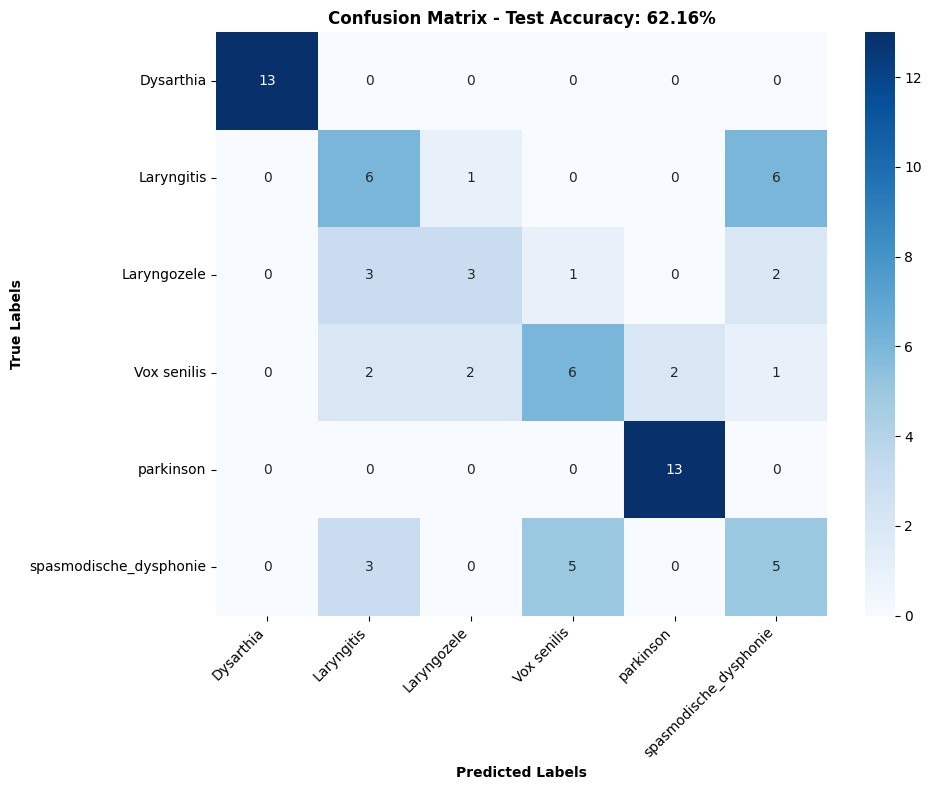

In [16]:
# %%
# Final Evaluation on the TEST SET
print("\n=== FINAL EVALUATION ON TEST SET ===")

# --- FIX: Manually load the state_dict and remove the problematic keys ---
# Load the saved state dictionary into a variable
state_dict = torch.load('best_full_model.pth', map_location=device)

# These keys have batch-size dependent shapes and are not needed for evaluation.
# We remove them to prevent the size mismatch error.
keys_to_remove = [
    'hierarchical_blocks.0.ema_grad',
    'hierarchical_blocks.1.ema_grad'
]
for key in keys_to_remove:
    if key in state_dict:
        del state_dict[key]
        print(f"Removed '{key}' from state_dict to prevent loading error.")

# Now, load the modified state_dict into the model
model.load_state_dict(state_dict, strict=False) # Use strict=False as a safeguard

# --- The rest of your code remains the same ---
test_dataset = MelSpectrogramDataset(config['base_dir'], 'test', val_transform)
test_loader = DataLoader(
    test_dataset, batch_size=config['batch_size'], shuffle=False,
    num_workers=config['num_workers'], pin_memory=config['pin_memory']
)

# Use the original criterion from training for a consistent loss calculation
criterion = nn.CrossEntropyLoss(label_smoothing=config['label_smoothing'])
test_loss, test_acc, test_preds, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"\nFinal Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"Final Test Loss: {test_loss:.4f}")

print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes, digits=4))

def plot_confusion_matrix(true_labels, predictions, class_names, acc):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels', fontweight='bold')
    plt.ylabel('True Labels', fontweight='bold')
    plt.title(f'Confusion Matrix - Test Accuracy: {acc:.2%}', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(test_labels, test_preds, test_dataset.classes, test_acc)


=== VISUALIZING TRAINING HISTORY ===


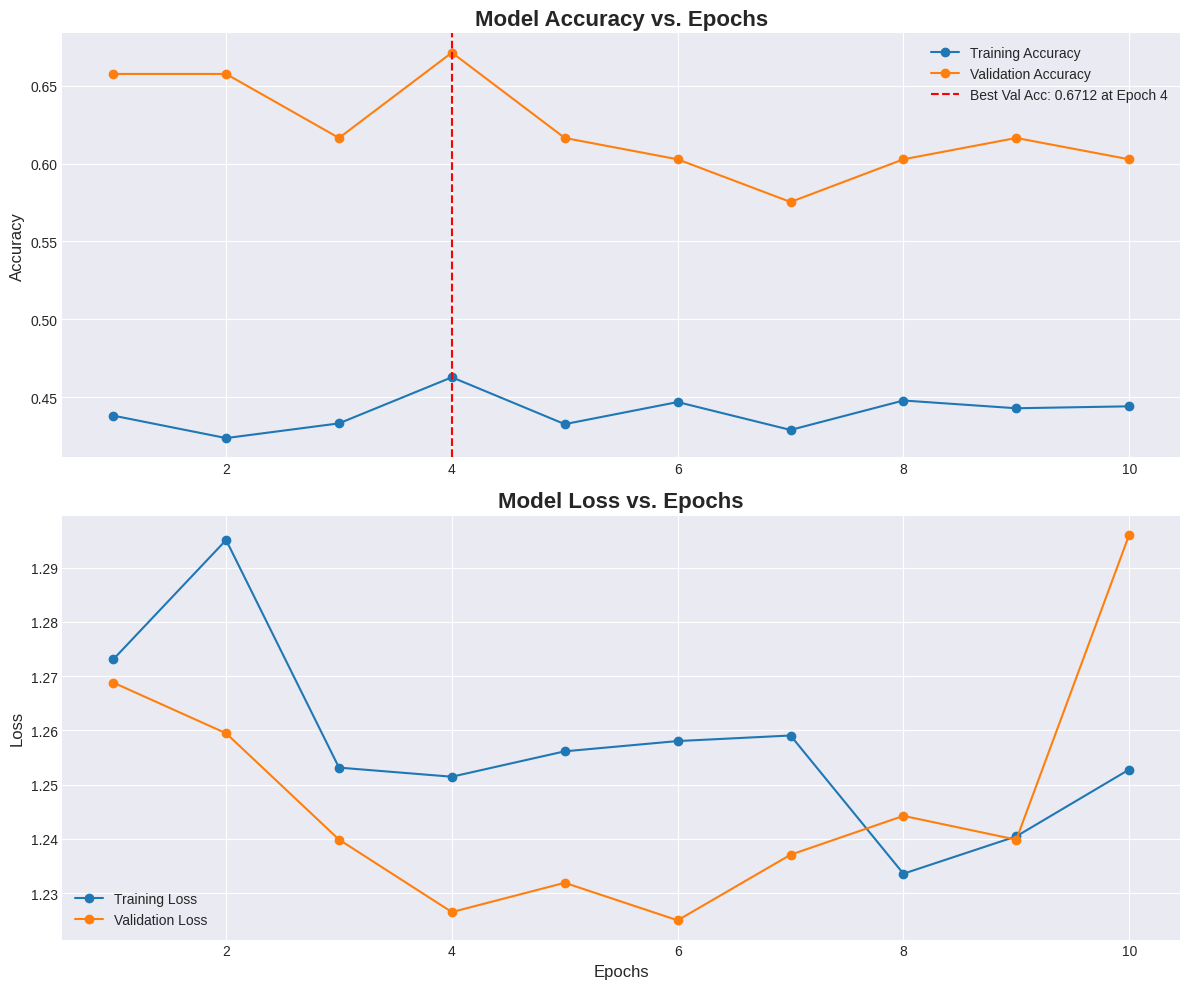

In [17]:
# %%
# Plotting Training History
print("\n=== VISUALIZING TRAINING HISTORY ===")
epochs_ran = range(1, len(history['train_loss']) + 1)
plt.style.use('seaborn-v0_8-darkgrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(epochs_ran, history['train_acc'], 'o-', label='Training Accuracy')
ax1.plot(epochs_ran, history['val_acc'], 'o-', label='Validation Accuracy')
ax1.set_title('Model Accuracy vs. Epochs', fontsize=16, fontweight='bold')
ax1.set_ylabel('Accuracy', fontsize=12)
best_epoch = history['val_acc'].index(max(history['val_acc'])) + 1
best_acc_val = max(history['val_acc'])
ax1.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Val Acc: {best_acc_val:.4f} at Epoch {best_epoch}')
ax1.legend()
ax2.plot(epochs_ran, history['train_loss'], 'o-', label='Training Loss')
ax2.plot(epochs_ran, history['val_loss'], 'o-', label='Validation Loss')
ax2.set_title('Model Loss vs. Epochs', fontsize=16, fontweight='bold')
ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
plt.tight_layout()
plt.show()

In [20]:
# %%
# Final Fine-Tuning Phase
print("\n=== FINAL FINE-TUNING PHASE ===")
FT_EPOCHS = 15
FT_LEARNING_RATE = 5e-6
BEST_MODEL_PATH = 'best_full_model.pth'
FINETUNED_MODEL_PATH = 'best_finetuned_model.pth'

_, ft_transform = get_enhanced_transforms(config['img_size'])
train_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'train', ft_transform)
val_dataset_ft = MelSpectrogramDataset(config['base_dir'], 'validation', ft_transform)
train_loader_ft = DataLoader(train_dataset_ft, batch_size=config['batch_size'], shuffle=True)
val_loader_ft = DataLoader(val_dataset_ft, batch_size=config['batch_size'], shuffle=False)

# Load the state dict and remove the problematic keys
state_dict = torch.load(BEST_MODEL_PATH)
keys_to_remove = [
    'hierarchical_blocks.0.ema_grad',
    'hierarchical_blocks.1.ema_grad'
]
for key in keys_to_remove:
    if key in state_dict:
        del state_dict[key]
        print(f"Removed '{key}' from state_dict.")

model.load_state_dict(state_dict, strict=False)
print(f"✅ Loaded weights from '{BEST_MODEL_PATH}'")

optimizer = optim.AdamW(model.parameters(), lr=FT_LEARNING_RATE, weight_decay=config['weight_decay'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=FT_EPOCHS)
criterion_ft = nn.CrossEntropyLoss()
original_mixup = config['mixup_alpha']
config['mixup_alpha'] = 0.0  # Disable mixup for fine-tuning
best_ft_acc = 0.0

for epoch in range(FT_EPOCHS):
    print(f"\nFine-Tuning Epoch {epoch+1}/{FT_EPOCHS}, LR: {optimizer.param_groups[0]['lr']:.2e}")
    train_loss, train_acc = train_epoch(model, train_loader_ft, criterion_ft, optimizer, device)
    val_loss, val_acc, _, _ = validate_epoch(model, val_loader_ft, criterion_ft, device)
    scheduler.step()
    print(f"FT - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"FT - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_ft_acc:
        best_ft_acc = val_acc
        torch.save(model.state_dict(), FINETUNED_MODEL_PATH)
        print(f"💾 New best fine-tuned model saved! Accuracy: {val_acc:.4f}")

config['mixup_alpha'] = original_mixup
print(f"\n✅ Fine-tuning complete! Best accuracy: {best_ft_acc:.4f}")


=== FINAL FINE-TUNING PHASE ===
Found 4021 images in train set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Found 73 images in validation set
Classes: ['Dysarthia', 'Laryngitis', 'Laryngozele', 'Vox senilis', 'parkinson', 'spasmodische_dysphonie']
Removed 'hierarchical_blocks.0.ema_grad' from state_dict.
Removed 'hierarchical_blocks.1.ema_grad' from state_dict.
✅ Loaded weights from 'best_full_model.pth'

Fine-Tuning Epoch 1/15, LR: 5.00e-06


Validation: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s, Loss=1.3386]


FT - Train Loss: 0.9716, Train Acc: 0.6031
FT - Val Loss: 0.9897, Val Acc: 0.6575
💾 New best fine-tuned model saved! Accuracy: 0.6575

Fine-Tuning Epoch 2/15, LR: 4.95e-06


Validation: 100%|██████████| 15/15 [00:01<00:00,  7.53it/s, Loss=1.3593]


FT - Train Loss: 0.9442, Train Acc: 0.6041
FT - Val Loss: 0.9655, Val Acc: 0.6575

Fine-Tuning Epoch 3/15, LR: 4.78e-06


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, Loss=1.3678]


FT - Train Loss: 0.9363, Train Acc: 0.6113
FT - Val Loss: 0.9542, Val Acc: 0.6575

Fine-Tuning Epoch 4/15, LR: 4.52e-06


Validation: 100%|██████████| 15/15 [00:02<00:00,  7.39it/s, Loss=1.4033]


FT - Train Loss: 0.9254, Train Acc: 0.6120
FT - Val Loss: 0.9534, Val Acc: 0.6438

Fine-Tuning Epoch 5/15, LR: 4.17e-06


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, Loss=1.3794]


FT - Train Loss: 0.9039, Train Acc: 0.6250
FT - Val Loss: 0.9435, Val Acc: 0.6301

Fine-Tuning Epoch 6/15, LR: 3.75e-06


Validation: 100%|██████████| 15/15 [00:02<00:00,  7.34it/s, Loss=1.4310]


FT - Train Loss: 0.9123, Train Acc: 0.6153
FT - Val Loss: 0.9468, Val Acc: 0.6027

Fine-Tuning Epoch 7/15, LR: 3.27e-06


Validation: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, Loss=1.4364]


FT - Train Loss: 0.8956, Train Acc: 0.6240
FT - Val Loss: 0.9404, Val Acc: 0.6027

Fine-Tuning Epoch 8/15, LR: 2.76e-06


Training:  30%|██▉       | 241/805 [00:52<02:01,  4.63it/s, Loss=0.3912]


KeyboardInterrupt: 


=== EVALUATING FINE-TUNED MODEL ON TEST SET ===
Removed 'hierarchical_blocks.0.ema_grad' from fine-tuned state_dict.
Removed 'hierarchical_blocks.1.ema_grad' from fine-tuned state_dict.


Validation: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, Loss=1.1565]



Final Fine-Tuned Test Accuracy: 0.6486 (64.86%)
Final Fine-Tuned Test Loss: 0.9102

Fine-Tuned Test Set Classification Report:
                        precision    recall  f1-score   support

             Dysarthia     1.0000    1.0000    1.0000        13
            Laryngitis     0.4375    0.5385    0.4828        13
           Laryngozele     0.5000    0.3333    0.4000         9
           Vox senilis     0.5455    0.4615    0.5000        13
             parkinson     0.8667    1.0000    0.9286        13
spasmodische_dysphonie     0.4615    0.4615    0.4615        13

              accuracy                         0.6486        74
             macro avg     0.6352    0.6325    0.6288        74
          weighted avg     0.6425    0.6486    0.6412        74



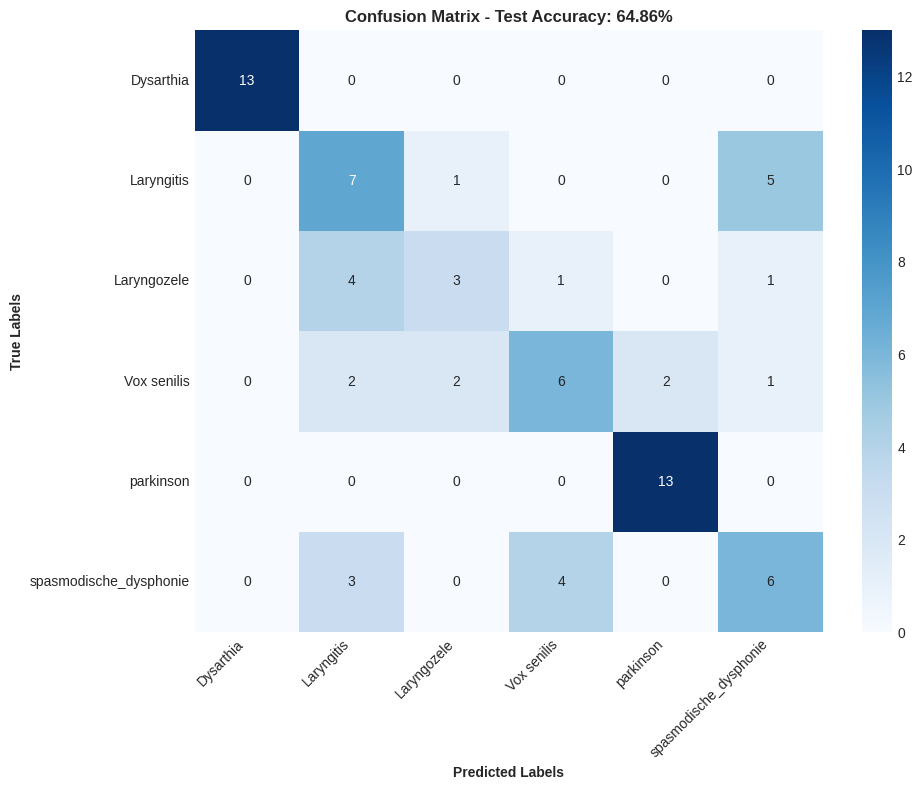

In [22]:
# %%
# Final Evaluation of Fine-Tuned Model
print("\n=== EVALUATING FINE-TUNED MODEL ON TEST SET ===")
# Load the state dict and remove the problematic keys
state_dict_ft = torch.load(FINETUNED_MODEL_PATH)
keys_to_remove = [
    'hierarchical_blocks.0.ema_grad',
    'hierarchical_blocks.1.ema_grad'
]
for key in keys_to_remove:
    if key in state_dict_ft:
        del state_dict_ft[key]
        print(f"Removed '{key}' from fine-tuned state_dict.")

model.load_state_dict(state_dict_ft, strict=False)

test_loss_ft, test_acc_ft, test_preds_ft, test_labels_ft = validate_epoch(model, test_loader, criterion_ft, device)
print(f"\nFinal Fine-Tuned Test Accuracy: {test_acc_ft:.4f} ({test_acc_ft:.2%})")
print(f"Final Fine-Tuned Test Loss: {test_loss_ft:.4f}")
print("\nFine-Tuned Test Set Classification Report:")
print(classification_report(test_labels_ft, test_preds_ft, target_names=test_dataset.classes, digits=4))
plot_confusion_matrix(test_labels_ft, test_preds_ft, test_dataset.classes, test_acc_ft)